# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

Примечание: как и на предыдущей неделе, буду пытаться улучшить градиентный бустинг по метрике AUC ROC.

In [2]:
#libraries import 
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from random import sample
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('train_churn.csv', header = 0)
y = df['Churn'].values
X_1 = df.iloc[:, :190].dropna(axis = 1, how = 'all').fillna(0).values

df_2 = df.iloc[:,:190].dropna(axis = 1, how = 'all')
for feature in df_2.columns:
    df_2['Sq'+feature] = df_2[feature] ** 2
X_2 = df_2.fillna(0).values

In [4]:
gb_class = GradientBoostingClassifier(random_state = 147)
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 147)
roc_pol = []
for X in [X_1, X_2]:
    roc_pol.append(np.mean(cross_val_score(gb_class, X, y, cv = skf, scoring = 'roc_auc')))
print(roc_pol)

[0.71834739390888647, 0.71992592456438698]


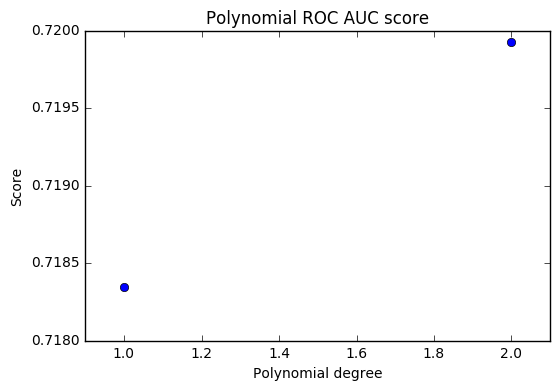

In [7]:
x = [1, 2]
plt.plot(x, roc_pol, 'o')
plt.xlabel('Polynomial degree')
plt.ylabel('Score')
plt.xlim(0.9, 2.1)
plt.ylim(0.718, 0.72)
plt.title('Polynomial ROC AUC score')
plt.show()

В связи с не самой удобной реализацией обработки категориальных признаков (`LabelEncoder` работает только с векторами, а не с матрицами, то есть нельзя передать сразу всю матрицу категориальных признаков, кроме того он выдает ошибку, если в тестовой выборке встречается отсутствующая в обучающей выборке категория), функция работает следующим образом:
* она принимает на вход обучающий и тестовый датасет, метод обработки пропущенных числовых значений, максимальное число категорий в категориальных признаках, количество числовых признаков, метод обработки категориальных признаков и название признака метки класса, и выдает обучающую и тестовую матрицу признаков и обучающий и тестовый вектор классов
* создаем датасет, объединяющий обучающий и тестовый, по нему определяем признаки, имеющие максимально допустимое число категорий
* обрабатываем числовые признаки обучающего и тестового датасета, в тестовом для замены используем `imputer.transform` 
* считаем частоту категорий признаков с числом категорий выше определенного для обучающего и тестового датасета
* преобразовываем категории в числа `le.fit_transform` для объединенного датасета, `le.transform` для обучающего и тестового
* используем `OneHotEncoder`
* объединяем полученные матрицы в одну матрицу признаков

In [15]:
#train and test feature matrix and class vector creation function
le = LabelEncoder()
ohe = OneHotEncoder()
df = pd.read_csv('train_churn.csv', header = 0)
df_test = pd.read_csv('test_churn.csv', header = 0)

def feature_matrix(df, df_test, na_val, max_cat, n_num = 190, na_cat = 'na', label = 'Churn'):
    df_all = pd.concat([df, df_test])
    df_all = df_all.iloc[:,n_num:].dropna(axis = 1, how = 'all').fillna(na_cat)
    cat_columns = df_all.columns
    cat_sorted = df_all.drop(label, axis = 1).describe().iloc[1,:].sort_values()
    
    df_num = df.iloc[:,:n_num].dropna(axis = 1, how = 'all')
    df_test_num = df_test.iloc[:,:n_num].dropna(axis = 1, how = 'all')    
    for feature in df_num.columns:
        df_num['Sq'+feature] = df_num[feature] ** 2
        df_test_num['Sq'+feature] = df_test_num[feature] ** 2
    if na_val in ['mean', 'median', 'most_frequent']:
        imputer = Imputer(strategy = na_val)
        X_num = df_num.values
        X_num = imputer.fit_transform(X_num)
        X_test_num = df_test_num.values
        X_test_num = imputer.transform(X_test_num)
    else:
        X_num = df_num.fillna(na_val).values
        X_test_num = df_test_num.fillna(na_val).values
        
    df_cat = df.iloc[:,n_num:]
    df_cat.fillna(na_cat, inplace = True)
    df_test_cat = df_test.iloc[:,n_num:]
    df_test_cat.fillna(na_cat, inplace = True)
    
    df_part = df_cat[list(cat_sorted[cat_sorted > max_cat].index)]
    df_test_part = df_test_cat[list(cat_sorted[cat_sorted > max_cat].index)]
    for feature in df_part.columns:
        df_part[feature] = df_part[feature].map(df_part.groupby(feature).size()) / len(df_part)
        df_test_part[feature] = df_test_part[feature].map(df_test_part.groupby(feature).size()) / len(df_test_part)
    
    X_part = df_part.values
    X_train = np.concatenate((X_num, X_part), axis = 1)
    y_train = df[label].values
    X_test_part = df_test_part.values
    X_test = np.concatenate((X_test_num, X_test_part), axis = 1)
    y_test = df_test[label].values
    
    if max_cat >= 2:
        df_all = df_all[list(cat_sorted[cat_sorted <= max_cat].index)]
        df_ohe = df_cat[list(cat_sorted[cat_sorted <= max_cat].index)]
        df_test_ohe = df_test_cat[list(cat_sorted[cat_sorted <= max_cat].index)]
        for feature in df_all.columns:
            df_all[feature] = le.fit_transform(df_all[feature].values)
            df_ohe[feature] = le.transform(df_ohe[feature].values)
            df_test_ohe[feature] = le.transform(df_test_ohe[feature].values)
        X_ohe = ohe.fit_transform(df_ohe.values)
        X_test_ohe = ohe.transform(df_test_ohe.values)
        X_train = np.concatenate((X_train, X_ohe.toarray()), axis = 1)
        X_test = np.concatenate((X_test, X_test_ohe.toarray()), axis = 1)
    return(X_train, y_train, X_test, y_test)

In [16]:
X_train_base, y_base, X_test, y_test = feature_matrix(df, df_test, na_val = 0, max_cat = 0)

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

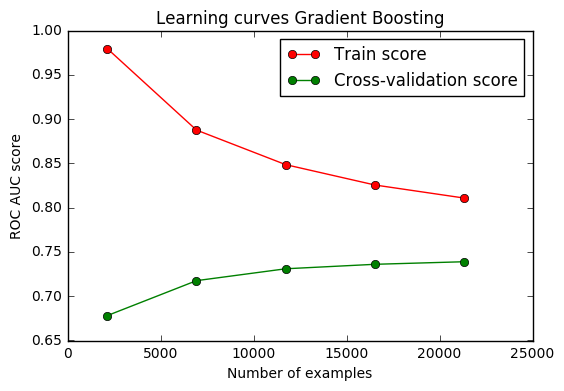

In [4]:
#learning curve visualization
gb_class = GradientBoostingClassifier()
train_size, train_score, test_score = learning_curve(gb_class, X_train_base, y_base, scoring = 'roc_auc')
train_mean = np.mean(train_score, axis = 1)
test_mean = np.mean(test_score, axis = 1)
plt.plot(train_size, train_mean, 'o-', color = 'r', label = 'Train score')
plt.plot(train_size, test_mean, 'o-', color = 'g', label = 'Cross-validation score')
plt.xlabel('Number of examples')
plt.ylabel('ROC AUC score')
plt.title('Learning curves Gradient Boosting')
plt.legend()
plt.show()

В данном случае мы построили кривую обучения с параметрами по умолчанию, из нее видно, что с увеличением выборки качество по кросс-валидации растет, но с ростом выборки разница становится все меньше. 

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [22]:
#creating oversampled dataframes
np.random.seed(147)
df_c = df[df['Churn'] == 1]
df_1c = df
df_2c = shuffle(pd.concat([df_1c, df_c]))
df_3c = shuffle(pd.concat([df_2c, df_c]))
df_4c = shuffle(pd.concat([df_3c, df_c]))
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 147)
gb_class = GradientBoostingClassifier(random_state = 147)

In [18]:
weights_roc = []
for df_w in [df_1c, df_2c, df_3c, df_4c]:
    X, y, X_test, y_test = feature_matrix(df_w, df_test, na_val = 0, max_cat = 0)
    weights_roc.append(np.mean(cross_val_score(gb_class, X, y, cv = skf, scoring = 'roc_auc')))
print(weights_roc)

[0.7365665151371058, 0.87176976598709643, 0.92834906059529343, 0.9543789445155102]


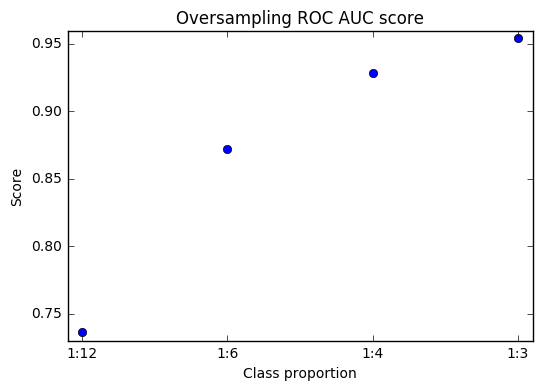

In [20]:
x = [1, 2, 3, 4]
labels = ['1:12', '1:6', '1:4', '1:3']
plt.plot(x, weights_roc, 'o')
plt.xlabel('Class proportion')
plt.ylabel('Score')
plt.xlim(0.9, 4.1)
plt.ylim(0.73, 0.96)
plt.xticks(x, labels)
plt.title('Oversampling ROC AUC score')
plt.show()

В градиентном бустинге нет параметра `class_weight`, поэтому проводилась балансировка классов путем добавления к датасету уже существующих наблюдений миноритарного класса. Использовалось приблизительно следующее соотношение классов: 1:12, 1:6, 1:4, 1:3. Кросс-валидация показывает, что оптимальным является соотношение 1:3, в данном случае качество классификации составляет 0.955 по метрике AUC ROC, но исследования показали, что в данном случае классификатор чересчур оптимистичный, и число False Positive даже выше, чем число True Negative. Дальше будет использоваться соотношение классов 1:4.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [52]:
#undersampling train and test matrix and class vector creation function
def undersampling_matrix(df, df_test, n_obs, na_val = 0, max_cat = 0, na_cat = 'na', 
                         n_num = 190, label = 'Churn', random = 147):
    np.random.seed(random)
    df_one = df[df[label] == 1]
    df_nc = df[df[label] == -1]
    random_index = sample(range(len(df_nc)), n_obs)
    df_random = df_nc.iloc[random_index, :]
    df_random = shuffle(pd.concat([df_random, df_one]))

    X, y, X_test, y_test = feature_matrix(df_random, df_test, na_val, max_cat, n_num, na_cat, label)
    return(X, y, X_test, y_test)

In [53]:
#ROC AUC for undersampling datasets
roc_under = []
for i in [2500, 5000, 7500, 10000]:
    X, y, X_test, y_test = undersampling_matrix(df, df_test, i)
    roc_under.append(np.mean(cross_val_score(gb_class, X, y, cv = skf, scoring = 'roc_auc')))
print(roc_under)

[0.73096174271050696, 0.72280177231966614, 0.73385712443366602, 0.73789223633748802]


В данном случае использовались следующие соотношения классов: 1:1, 1:2, 1:3, 1:4. Высшее качество получилось при  соотношении классов 1:4, тем не менее оно хуже, чем в прошлом случае, так как при этом мы используем только порядка 38% обучающей выборки. 

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [23]:
#ROC AUC values for different na values strategies
na_roc = [weights_roc[2]]
for na_val in [1e21, 'mean', 'median', 'most_frequent']:
    X, y, X_test, y_test = feature_matrix(df_3c, df_test, na_val = na_val, max_cat = 0)
    na_roc.append(np.mean(cross_val_score(gb_class, X, y, cv = skf, scoring = 'roc_auc')))
print(na_roc)

[0.92834906059529343, 0.92791484944084957, 0.92968357431324611, 0.9293619179124526, 0.92811938422050277]


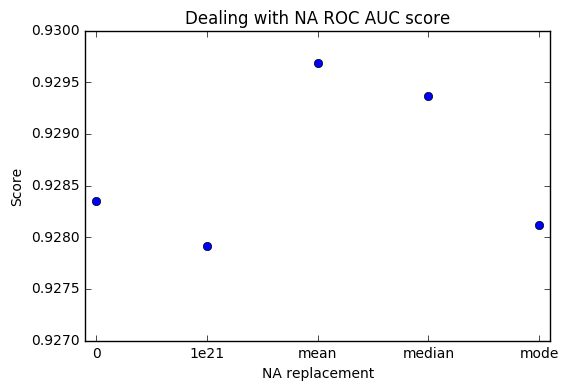

In [25]:
x = [1, 2, 3, 4, 5]
labels = ['0', '1e21', 'mean', 'median', 'mode']
plt.plot(x, na_roc, 'o')
plt.xlabel('NA replacement')
plt.ylabel('Score')
plt.xlim(0.9, 5.1)
plt.ylim(0.927, 0.93)
plt.xticks(x, labels)
plt.title('Dealing with NA ROC AUC score')
plt.show()

Пропущенные значения числовых признаков были заменены нулем, большим числом (достаточно целесообразный подход для классификации на решающих деревьях), модой, медианой и средним. Лучшим вариантом оказалась замена средним.
Пропущенные значения категориальных признаков заменены отдельной категорией для всех признаков. Альтернативой может быть замена самой популярной категорией.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [26]:
#ROC AUC for categorical variables
cat_roc = [max(na_roc)]
for i in [10, 30]:
    X, y, X_test, y_test = feature_matrix(df_3c, df_test, na_val = 'mean', max_cat = i)
    cat_roc.append(np.mean(cross_val_score(gb_class, X, y, cv = skf, scoring = 'roc_auc')))
print(cat_roc)

[0.92968357431324611, 0.9297099947069456, 0.92972006213061376]


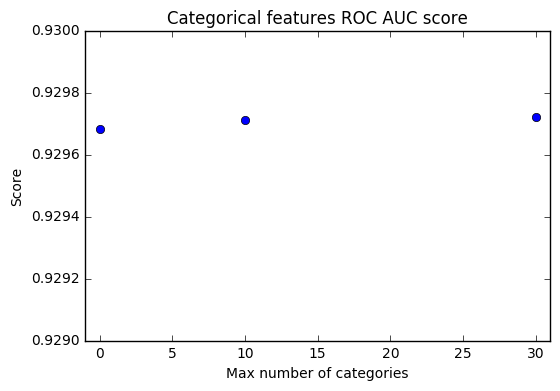

In [31]:
x = [0, 10, 30]
plt.plot(x, cat_roc, 'o')
plt.xlabel('Max number of categories')
plt.ylabel('Score')
plt.xlim(-1, 31)
plt.ylim(0.929, 0.93)
plt.title('Categorical features ROC AUC score')
plt.show()

В данном случае помимо замены каждой категории ее частотой еще использовались следующие подходы:
* one hot encoding, если число категорий меньше 10 и частота если больше
* one hot encoding, если число категорий меньше 30 и частота если больше

Опитмальным является вариант с 30 категориями.

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [32]:
X_train, y_train, X_test, y_test = feature_matrix(df_3c, df_test, na_val = 'mean', max_cat = 30)

In [33]:
# selecting non zero coefficients for l1-regularization model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
lasso_rate = [1, 0.1, 0.01]
indexes = []
indexes_nz = []
for C in lasso_rate:
    lr_class = LogisticRegression(penalty = 'l1', C = C)
    lr_class.fit(X_scaled, y_train)
    indexes.append(np.where(lr_class.coef_ == 0)[1])
    indexes_nz.append(np.where(lr_class.coef_ != 0)[1])
    print((lr_class.coef_ == 0).sum())

94
190
454


In [34]:
# ROC AUC for feature selection by l1 model
lasso_roc = [max(cat_roc)]
for i in range(3):
    lasso_roc.append(np.mean(cross_val_score(gb_class, np.delete(X_train, indexes[i], axis = 1), 
                                     y_train, cv = skf, scoring = 'roc_auc')))
print(lasso_roc)

[0.92972006213061376, 0.92953213428279136, 0.91355521277338514, 0.87343945752952767]


In [35]:
# ROC AUC for SelectFromModel
gb_class.fit(X_train, y_train)
model = SelectFromModel(gb_class, prefit = True)
X_train_fm = model.transform(X_train)
lasso_roc.append(np.mean(cross_val_score(gb_class, X_train_fm, y_train, cv = skf, scoring = 'roc_auc')))
print(lasso_roc, X_train_fm.shape, X_train.shape)

[0.92972006213061376, 0.92953213428279136, 0.91355521277338514, 0.87343945752952767, 0.92997010444379535] (36762, 64) (36762, 566)


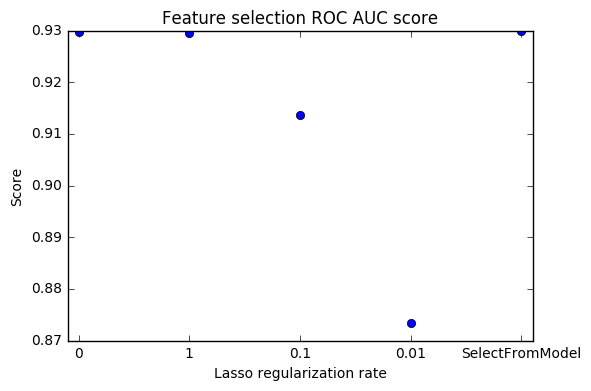

In [37]:
x = [1, 2, 3, 4, 5]
labels = ['0', '1', '0.1', '0.01', 'SelectFromModel']
plt.plot(x, lasso_roc, 'o')
plt.xlabel('Lasso regularization rate')
plt.ylabel('Score')
plt.xlim(0.9, 5.1)
plt.ylim(0.87, 0.93)
plt.xticks(x, labels)
plt.title('Feature selection ROC AUC score')
plt.show()

Мы проверили два метода выбора модели: SelectFromModel и логистическая регрессия с l1-регуляризацией. В первом случае мы смогли улучить качество модели, l1-регуляризация немного качество ухудшила, кроме последнего случая, когда мы очень сильно штрафуем модель, то качество уменьшается довольно сильно.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [8]:
# best parametres
grid = {'n_estimators': [50, 100, 147], 'max_depth': [2, 3, 4], 'max_features': ['sqrt', 'log2']}
gs = GridSearchCV(gb_class, grid, cv = skf, scoring = 'roc_auc')
gs.fit(X_train_fm, y_train)
print(gs.best_score_, gs.best_params_)

0.93938864575 {'max_features': 'sqrt', 'n_estimators': 147, 'max_depth': 4}


В данном случае мы настроивали следующие гиперпараметры:
* количество решающих деревьев
* максимальная глубина дерева
* максимальное число признаков для построения дерева

Подбор параметров помог еще улучшить качество модели. Проведя разные способы обработки данных, балансировки классов, отбора признаков и настройки параметров мы смогли улучшить качество по кросс-валидации с 0.737 до 0.938. Естественно эта оценка весьма оптимистична, так как тестовая выборка является несбалансированной, поэтому ошибок в классификации будет существенно больше, тем не менее балансировка позволит нам увеличить число правильно предсказанных наблюдений миноритарного класса.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [54]:
#feature importance
importance = pd.DataFrame(gs.best_estimator_.feature_importances_, columns = ['Importance'])
importance['Index'] = model.get_support(indices = True)
importance.sort_values('Importance', ascending = False, inplace = True)
importance

,Importance,Index
43,0.099281,357
45,0.074518,359
47,0.067959,361
46,0.053121,360
14,0.051857,114
32,0.038346,288
12,0.031512,101
39,0.024438,353
7,0.023315,62
23,0.022943,236


В качестве оценки важности переменных будем использовать `feature_importance_`. Отберем соответствующие им индексы признаков в базовой матрице признаков и отсортируем их по убыванию важности. Мы видим, что наиболее значимы переменные с индексами 357, 359, 361, 360 и 114. Стоит отметить, что среди них 4 являются категориальными, и только один числовым.  Наименьший же вклад внесли признаки с индексами 440, 86, 423, 476, 393. Не считая конечно же признаков, которые признаны незначительными SelectFromModel.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [9]:
y_pred = gs.predict_proba(model.transform(X_test))

In [12]:
df_test['Churn error'] = df_test['Churn'].values - y_pred[:,0]
df_test['Non churn error'] = df_test['Churn'].values - y_pred[:,1]

In [32]:
df_test_ce = df_test[df_test['Churn'] == 1].sort_values('Churn error').drop('Non churn error', axis = 1)
df_test_ce = df_test_ce[df_test_ce['Churn error'] <= 0.15]
df_test_nce = df_test[df_test['Churn'] == -1].sort_values('Non churn error').drop('Churn error', axis = 1)
df_test_nce = df_test_nce[df_test_nce['Non churn error'] <= -1.85]
df_test_ce

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,Churn,Churn error
5479,NaN,NaN,NaN,NaN,NaN,770.0,21.0,NaN,NaN,NaN,...,M_8D,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,mj86,NaN,1,0.042313
6152,NaN,NaN,NaN,NaN,NaN,1001.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,uWr3,RAYp,55YFVY9,am7c,NaN,1,0.074402
1067,NaN,NaN,NaN,NaN,NaN,2254.0,0.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,me1d,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.081885
359,NaN,NaN,NaN,NaN,NaN,189.0,0.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,7aLG,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.084550
74,NaN,NaN,NaN,NaN,NaN,1204.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.084917
4566,NaN,NaN,NaN,NaN,NaN,329.0,0.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,Aoh3,ZI9m,F2FcTt7IdMT_v,NaN,NaN,1,0.085103
1817,NaN,NaN,NaN,NaN,NaN,539.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,szEZ,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.086002
5035,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.087596
5677,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.087635
72,NaN,NaN,NaN,NaN,NaN,1491.0,14.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,WqMG,6fzt,Zy3gnGM,mj86,NaN,1,0.087907


In [33]:
df_test_nce

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,Churn,Non churn error
7227,NaN,NaN,NaN,NaN,NaN,539.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,ELof,5Acm,RAYp,F2FyR07IdsN7I,NaN,NaN,-1,-1.893160
6693,NaN,NaN,NaN,NaN,NaN,784.0,0.0,NaN,NaN,NaN,...,M_8D,NaN,kG3k,Aoh3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1,-1.893038
2639,NaN,NaN,NaN,NaN,NaN,658.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,mj86,NaN,-1,-1.890095
3231,NaN,NaN,NaN,NaN,NaN,511.0,0.0,NaN,NaN,NaN,...,jySVZNlOJy,NaN,ELof,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,-1,-1.889255
5167,NaN,NaN,NaN,NaN,NaN,1323.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,ELof,uWr3,RAYp,F2FyR07IdsN7I,mj86,NaN,-1,-1.881495
2331,NaN,NaN,NaN,NaN,NaN,1253.0,7.0,NaN,NaN,NaN,...,jySVZNlOJy,NaN,ELof,Xa3G,nIGXDli,F2FyR07IdsN7I,am7c,NaN,-1,-1.877853
4496,NaN,NaN,NaN,NaN,NaN,833.0,7.0,NaN,NaN,NaN,...,M_8D,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,am7c,NaN,-1,-1.877438
218,NaN,NaN,NaN,NaN,NaN,763.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,ELof,Aoh3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1,-1.875298
3287,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,jySVZNlOJy,NaN,kG3k,5Acm,RAYp,F2FyR07IdsN7I,am7c,NaN,-1,-1.873679
3929,NaN,NaN,NaN,NaN,NaN,1274.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,kG3k,FSa2,02N6s8f,R4y5gQQWY8OodqDV,mj86,NaN,-1,-1.866478


In [31]:
df_mean_error = pd.concat([df_test_ce.describe().iloc[1:3,:], df_test_nce.describe().iloc[1:3,:]]).dropna(axis = 1)
df_mean_error

,Churn,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var13,Var132,...,Var7,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94
mean,1.0,42.133333,43.733333,-6.400565e+05,681.666667,43.200000,15152.142857,-17.00000,935.714286,1.600000,...,7.500000,4.636364,41.083333,150.000000,1.497470e+06,0.00000,116220.136000,14.666667,6.533333,95504.181818
std,0.0,37.458294,54.917427,1.029818e+06,564.878832,48.331002,16715.391856,18.18743,1186.097378,4.484895,...,6.980743,3.107176,41.131725,317.541033,1.939191e+06,0.00000,86197.201731,16.633300,7.110020,114192.190827
mean,-1.0,56.941176,44.400000,2.280061e+05,719.750000,49.800000,22901.400000,4.00000,240.600000,1.200000,...,4.200000,3.375000,66.900000,16.800000,1.151720e+06,0.15000,129495.110150,14.500000,6.800000,81208.875000
std,0.0,82.843580,80.523550,2.878925e+05,720.368099,43.270994,45511.342113,0.00000,308.059529,3.914884,...,3.518373,1.060660,15.511965,49.257220,1.672882e+06,0.67082,83011.214932,14.858986,11.114713,73396.033564


Выше представлены наблюдения, для которых ошибка классификатора составляет более 85%, то есть классификатор дает вероятность принадлежности к ошибочному классу более 0.85. На первый взгляд не видно никаких закономерностей, но если посмотреть на средние численных признаков, то видно, что они могут сильно отличаться, может быть, значение этих признаков более характерно для противоположного класса. 

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

В качестве финальной модели будет использована построенная выше модель. Метод построения:
* Производится балансировка классов, чтобы отношение оттока и не оттока было 1:4
* Удаляются переменные, состоящие только из пропущенных значений, добавляются квадраты числовых значений
* Пропущенные значения числовых переменных заменяются на среднее, категориальные делаются отдельной категорией
* Категориальные переменные с числом категорий менее 30 кодируются с помощью one hot encoding, для остальных категория заменяется ее частотой
* На данной матрице признаков отбираются признаки с помощью SelectFromModel
* На уменьшенной матрице признаков строится градиентный бустинг на 147 деревьях с максимальной глубиной 4.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Модель улучшить можно всегда. Можно дальше экспериментировать с обработкой признаков, отбором признаков, балансировкой классов, настройкой гиперпараметров. Наконец можно попытаться построить другую модель, используя иной алгоритм классификации. 

In [38]:
y_pred_class = gs.predict(model.transform(X_test))
confusion_matrix(y_test, y_pred_class)

array([[5597, 1808],
       [ 324,  271]])